# Questão 2 - Regressão
Teste dois métodos de aprendizagem de máquina para identificar o que apresenta melhores resultados na previsão do volume de tráfego. Avaliem o impacto de usar validação cruzada (com 10 grupos) e split (70% para treinamento e 30% para teste). Para esse último, execute o experimento duas vezes selecionando as instâncias aleatoriamente para o treinamento e teste e avalie o impacto nos resultados.
Outras informações como dia da semana podem ser inclusas.
 

## Preliminares
Importação de dependências, carregamento da base de dados e observação inicial dos dados.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', delimiter = ',') # Abrir base de dados

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.info() # Obter informações sobre os atributos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Os atributos do tipo object terão de ser analisados e convertidos para valores numéricos mais adiante, no caso de que venham a permanecer na base de dados.

In [4]:
df.isnull().sum() # Obter numero de valores faltando

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

Como nenhum valor está faltando, nenhuma ação adicional foi tomada para corrigir dados ausentes.

## Tratando atributos não numéricos

In [5]:
print("Valores únicos de holiday:", df['holiday'].unique(), "\n")
print("Valores únicos de weather_main:", df['weather_main'].unique(), "\n")
print("Valores únicos de weather_description:", df['weather_description'].unique(), "\n")

Valores únicos de holiday: ['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day'] 

Valores únicos de weather_main: ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke'] 

Valores únicos de weather_description: ['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'Sky is Clear' 'very heavy rain'
 'thund

### Holiday

None                         48143
Labor Day                        7
Christmas Day                    6
Martin Luther King Jr Day        6
New Years Day                    6
Thanksgiving Day                 6
Memorial Day                     5
State Fair                       5
Columbus Day                     5
Independence Day                 5
Veterans Day                     5
Washingtons Birthday             5
Name: holiday, dtype: int64


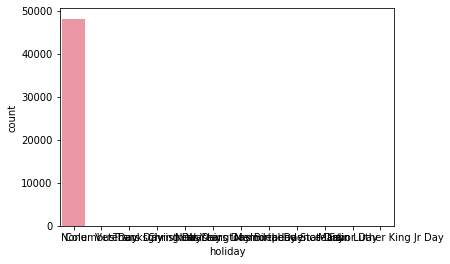

In [6]:
sns.countplot(df['holiday'])
count = df['holiday'].value_counts()
print(count)

O atributo Holiday está bastante desbalanceado, o que é de se imaginar pois cada feriado só acontece uma vez por ano. Logo, foi optado por remover este atributo para evitar gerar um viés no resultado obtido.

In [7]:
df.drop(columns = ['holiday'], inplace = True)

### weather_main e weather_description

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

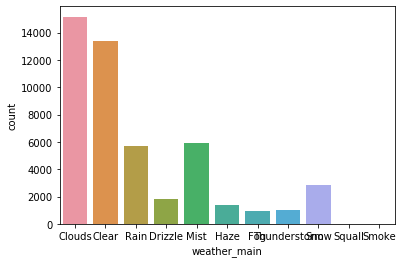

In [8]:
sns.countplot(df['weather_main'])
count = df['weather_main'].value_counts()
count

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

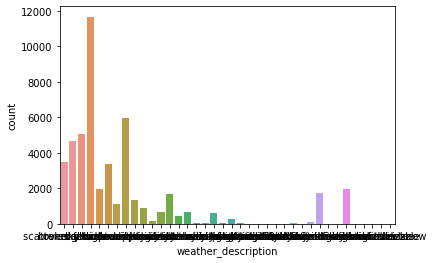

In [9]:
sns.countplot(df['weather_description'])
count = df['weather_description'].value_counts()
count

Há um certo grau de desbalanceamento nestas duas variáveis, sendo que weather_description funciona como uma extensão do weather_main, tanto que cada valor distinto de weather_description está associado ao mesmo valor de weather_main:

In [10]:
for unique_weather in df['weather_main'].unique() :
    loc = df.loc[df['weather_main'] == unique_weather]
    print("Descricoes para", unique_weather, ":", loc['weather_description'].unique())

Descricoes para Clouds : ['scattered clouds' 'broken clouds' 'overcast clouds' 'few clouds']
Descricoes para Clear : ['sky is clear' 'Sky is Clear']
Descricoes para Rain : ['light rain' 'proximity shower rain' 'moderate rain'
 'heavy intensity rain' 'freezing rain' 'light intensity shower rain'
 'very heavy rain']
Descricoes para Drizzle : ['light intensity drizzle' 'drizzle' 'heavy intensity drizzle'
 'shower drizzle']
Descricoes para Mist : ['mist']
Descricoes para Haze : ['haze']
Descricoes para Fog : ['fog']
Descricoes para Thunderstorm : ['proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'thunderstorm with heavy rain'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'thunderstorm with light drizzle'
 'thunderstorm with drizzle']
Descricoes para Snow : ['heavy snow' 'snow' 'shower snow' 'light rain and snow' 'light snow'
 'light shower snow' 'sleet']
Descricoes para Squall : ['SQUALLS']
Descricoes para Smoke :

Tendo em vista isso, foi optado por remover ambos os atributos 'weather_main' e 'weather_description' da base de dados.

In [11]:
df.drop(columns = ['weather_description', 'weather_main'], inplace = True)

### Date_time
Pro caso do atributo 'date_time' além de conter informações como dia, mês, ano e hora, também pode ser usado para criar outros atributos, como o caso para dia da semana. Logo, foi optado por dividir este atributo em outros 5 (dia, mês, ano, hora e dia da semana), sendo estes todos atributos numéricos.

In [12]:
#df['date_time'] = df['date_time'].apply(lambda s : s.split(" "))
dt = df['date_time'].to_list()
hours = []
years = []
months = []
days = []
weekdays = []

for d in dt:
    split = d.split(" ")
    split2 = split[0].split("-")
    
    years.append(int(split2[0]))
    months.append(int(split2[1]))
    days.append(int(split2[2]))
    
    hours.append(int(split[1].split(':')[0]))

for i in range(len(hours)):
    weekdays.append(datetime.datetime(years[i], months[i], days[i]).weekday())
    
dt_df = pd.DataFrame({"day": days, "month": months, "year": years, "hour": hours, "weekday": weekdays})

df = df.join(dt_df)
df = df.drop(columns = ['date_time'])
df

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,year,hour,weekday
0,288.28,0.0,0.0,40,5545,2,10,2012,9,1
1,289.36,0.0,0.0,75,4516,2,10,2012,10,1
2,289.58,0.0,0.0,90,4767,2,10,2012,11,1
3,290.13,0.0,0.0,90,5026,2,10,2012,12,1
4,291.14,0.0,0.0,75,4918,2,10,2012,13,1
...,...,...,...,...,...,...,...,...,...,...
48199,283.45,0.0,0.0,75,3543,30,9,2018,19,6
48200,282.76,0.0,0.0,90,2781,30,9,2018,20,6
48201,282.73,0.0,0.0,90,2159,30,9,2018,21,6
48202,282.09,0.0,0.0,90,1450,30,9,2018,22,6


## Analisando correlação

In [13]:
correl = df.corr()
correl.style.background_gradient(cmap = 'coolwarm')

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,year,hour,weekday
temp,1,0.00906854,-0.0197552,-0.101976,0.130299,0.0229017,0.223738,0.134945,0.112089,-0.00770762
rain_1h,0.00906854,1,-8.98346e-05,0.00481813,0.0047137,-0.00229363,0.00129768,0.000441939,0.00342121,-0.00691954
snow_1h,-0.0197552,-8.98346e-05,1,0.0279309,0.000733435,0.0157888,0.0204121,-0.00351937,0.00984913,-0.0149276
clouds_all,-0.101976,0.00481813,0.0279309,1,0.0670538,0.0481116,-0.00913346,-0.0728609,0.054418,-0.0397152
traffic_volume,0.130299,0.0047137,0.000733435,0.0670538,1,-0.00758739,-0.00253292,0.00475323,0.352401,-0.149544
day,0.0229017,-0.00229363,0.0157888,0.0481116,-0.00758739,1,0.00861361,0.0121924,-0.00937314,0.0086776
month,0.223738,0.00129768,0.0204121,-0.00913346,-0.00253292,0.00861361,1,-0.158688,0.00186516,0.010741
year,0.134945,0.000441939,-0.00351937,-0.0728609,0.00475323,0.0121924,-0.158688,1,-0.00754237,-0.012313
hour,0.112089,0.00342121,0.00984913,0.054418,0.352401,-0.00937314,0.00186516,-0.00754237,1,-0.00385763
weekday,-0.00770762,-0.00691954,-0.0149276,-0.0397152,-0.149544,0.0086776,0.010741,-0.012313,-0.00385763,1


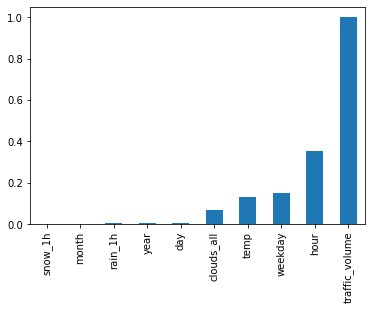

In [14]:
df.corr().abs()["traffic_volume"].sort_values().plot.bar()

A análise da correlação dos atributos mostra que todos os pares distintos possuem uma correlação fraca, em relação ao atributo desejado 'traffic_volume', os atributos 'snow_1h' 'month' 'rain_1h' 'year' e 'day' apresentam uma correlação baixíssima e portanto foram descartados, uma vez que estes não contribuem para determinar o valor do atributo alvo.

In [15]:
df.drop(columns = ['snow_1h', 'month', 'rain_1h', 'year', 'day'], inplace = True)

O atributo 'hour' é o que possui a maior correlação em relação a 'traffic_volume', contudo, isso pode ser explicado pelo fato de que os horários de pico coincidem com os maiores valores de hora:

Text(0, 0.5, 'Tráfego')

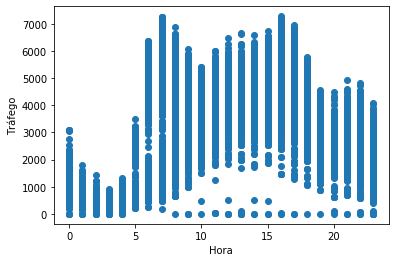

In [16]:
plt.scatter(df['hour'], df['traffic_volume'])
plt.xlabel("Hora")
plt.ylabel("Tráfego")

Ainda no gráfico acima é possível ver que existem vários outliers, contudo, por ora, não será tomada nenhuma ação adicional.

## Reescala de atributos
Para evitar dar um peso maior a um atributo específico é feita a reescala destes por meio da padronização, que pode vir a lidar melhor com outliers não tratados anteriormente.

In [17]:
num = df.select_dtypes(['float64', 'int64']).columns.values
num = np.delete(num, np.argwhere(num == 'traffic_volume'))

scaler = preprocessing.StandardScaler()
scaled = pd.concat([pd.DataFrame(scaler.fit_transform(df[num]), columns = num), df['traffic_volume']], axis=1)

scaled.head()

,temp,clouds_all,hour,weekday,traffic_volume
0,0.530370,-0.239963,-0.345548,-0.989561,5545
1,0.611341,0.657120,-0.201459,-0.989561,4516
2,0.627836,1.041584,-0.057371,-0.989561,4767
3,0.669071,1.041584,0.086718,-0.989561,5026
4,0.744794,0.657120,0.230807,-0.989561,4918


### Teste usando split 70/30 aleatório
Inicialmente é feita a divisão das partições usando 70% para treinamento e 30% para teste, esta divisão foi realizada duas vezes de maneira aleatória.

In [18]:
train1, test1 = model_selection.train_test_split(scaled.copy(), test_size = 0.3, shuffle = True)
train2, test2 = model_selection.train_test_split(scaled.copy(), test_size = 0.3, shuffle = True)

trainTarget1 = train1['traffic_volume'].copy()
testTarget1 = test1['traffic_volume'].copy()

train1.drop(columns = ['traffic_volume'], inplace = True)
test1.drop(columns = ['traffic_volume'], inplace = True)

trainTarget2 = train2['traffic_volume'].copy()
testTarget2 = test2['traffic_volume'].copy()

train2.drop(columns = ['traffic_volume'], inplace = True)
test2.drop(columns = ['traffic_volume'], inplace = True)

O primeiro algoritmo utilizado será o K-NN com k = 3

In [19]:
k = 3

knn = neighbors.KNeighborsRegressor(n_neighbors = k)
knn.fit(train1, trainTarget1)
resultKNN1 = knn.predict(test1)

knn.fit(train2, trainTarget2)
resultKNN2 = knn.predict(test2)

Após executar o algoritmo, podemos obter o erro médio quadrático (MSE) e o erro médio absoluto (MAD), além da medida R2 em cada uma das execuções:

In [20]:
print("(Run = 1)\nK-NN (k = %d)" % (k))
print("MSE: %0.5f" % (metrics.mean_squared_error(testTarget1, resultKNN1)))
print("MAD: %0.5f" % (metrics.mean_absolute_error(testTarget1, resultKNN1)))
print("R2: %0.5f" % (metrics.r2_score(testTarget1, resultKNN1)))

print("\n(Run = 2)\nK-NN (k = %d)" % (k))
print("MSE: %0.5f" % (metrics.mean_squared_error(testTarget2, resultKNN2)))
print("MAD: %0.5f" % (metrics.mean_absolute_error(testTarget2, resultKNN2)))
print("R2: %0.5f" % (metrics.r2_score(testTarget2, resultKNN2)))

(Run = 1)
K-NN (k = 3)
MSE: 299553.46684
MAD: 326.82854
R2: 0.92434

(Run = 2)
K-NN (k = 3)
MSE: 307617.70719
MAD: 328.58526
R2: 0.92181


Text(0.5, 0, 'Obtido')

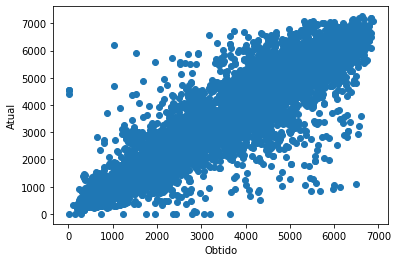

In [21]:
plt.scatter(resultKNN2, testTarget2)
plt.ylabel('Atual')
plt.xlabel('Obtido')

Em ambas execuções o resultado obtido foi muito parecido. As métricas e o gráfico obtidos acima levam a crer que o modelo conseguiu prever bem o atributo desejado na maior parte dos casos e de maneira consistente, pois mesmo utilizando conjuntos diferentes para treinamento e teste, os resultados obtidos foram semelhantes, porém, como visto no gráfico acima, falhou miseralvelmente em alguns casos, muito por conta da falta de tratamento adequado de outlier.

O segundo algoritmo utilizado será uma árvore de decisão para regressão, enquanto o conjunto de teste e treinamento utilizado será o mesmo do que foi utilizado no K-NN.

In [22]:
dtr = tree.DecisionTreeRegressor()

dtr.fit(train1, trainTarget1)
resultTree1 = dtr.predict(test1)

dtr.fit(train2, trainTarget2)
resultTree2 = dtr.predict(test2)

In [23]:
print("(Run = 1)\nDecision Tree Regression")
print("MSE: %0.5f" % (metrics.mean_squared_error(testTarget1, resultTree1)))
print("MAD: %0.5f" % (metrics.mean_absolute_error(testTarget1, resultTree1)))
print("R2: %0.5f" % (metrics.r2_score(testTarget1, resultTree1)))

print("\n(Run = 2)\nDecision Tree Regression")
print("MSE: %0.5f" % (metrics.mean_squared_error(testTarget2, resultTree2)))
print("MAD: %0.5f" % (metrics.mean_absolute_error(testTarget2, resultTree2)))
print("R2: %0.5f" % (metrics.r2_score(testTarget2, resultTree2)))

(Run = 1)
Decision Tree Regression
MSE: 347678.77888
MAD: 301.49770
R2: 0.91218

(Run = 2)
Decision Tree Regression
MSE: 360652.40477
MAD: 303.10583
R2: 0.90833


Text(0.5, 0, 'Obtido')

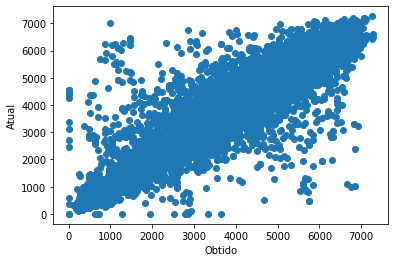

In [24]:
plt.scatter(resultTree2, testTarget2)
plt.ylabel('Atual')
plt.xlabel('Obtido')

Usando a árvore de decisão os resultados obtidos foram bastante semelhantes ao do K-NN e também consistentes, contudo, o KNN foi ligeiramente superior nas métricas R2 e no erro médio quadrático (MSE), enquanto a árvore apresentou resultados melhores no caso do erro médio absoluto. Porém, assim como no K-NN, a árvore de decisão errou por muito em alguns casos, provavelmente por conta da falta de tratamento adequado de outliers realizado na base de dados. Por fim, em ambos os testes e algoritmos, não aparenta ter acontecido um caso de overfitting ou underfitting, pelo fato de que mesmo atuando sobre conjuntos diferentes o resultado obtido foi praticamente igual.

## Teste usando validação cruzada
Utilizando os mesmos algoritmos acima, agora os dados serão divididos em 10 grupos, sendo 9 utilizados para treinamento e 1 utilizado para teste, onde os algoritmos serão executados sobre estes grupos repetidamente até que todo grupo ter sido usado para teste.

In [28]:
fold = model_selection.KFold(n_splits = 10, shuffle = True)

X = scaled.copy(deep = True)
Y = X['traffic_volume']

X.drop(columns = ['traffic_volume'], inplace = True)

k = 3
i = 1

knn = neighbors.KNeighborsRegressor(n_neighbors = k)
dtr = tree.DecisionTreeRegressor()
mse_knn = mad_knn = r2_knn = 0
mse_dtr = mad_dtr = r2_dtr = 0

for train_index, test_index in fold.split(scaled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    knn.fit(X_train, Y_train)
    resultKNN = knn.predict(X_test)
    
    mse_knn = mse_knn + metrics.mean_squared_error(Y_test, resultKNN)
    mad_knn = mad_knn + metrics.mean_absolute_error(Y_test, resultKNN)
    r2_knn = r2_knn + metrics.r2_score(Y_test, resultKNN)
    
    dtr.fit(X_train, Y_train)
    resultDTR = dtr.predict(X_test)
    
    mse_dtr = mse_dtr + metrics.mean_squared_error(Y_test, resultDTR)
    mad_dtr = mad_dtr + metrics.mean_absolute_error(Y_test, resultDTR)
    r2_dtr = r2_dtr + metrics.r2_score(Y_test, resultDTR)

print("KNN (k = %d)" % (k))
print("MSE: %0.5f" % (mse_knn / 10))
print("MAD: %0.5f" % (mad_knn / 10))
print("R2: %0.5f" % (r2_knn / 10))
print("DECISION TREE REGRESSION")
print("MSE: %0.5f" % (mse_dtr / 10))
print("MAD: %0.5f" % (mad_dtr / 10))
print("R2: %0.5f" % (r2_dtr / 10))

KNN (k = 3)
MSE: 284212.35528
MAD: 311.49458
R2: 0.92797
DECISION TREE REGRESSION
MSE: 343895.57196
MAD: 288.30751
R2: 0.91286


Usando a validação cruzada, os resultados obtidos foram similares em relação a aqueles vistos anteriormente usando o particionamento.

Novamente, o KNN mostrou ser ligeiramente superior a árvore de decisão. Em ambos os casos, não aparenta ter acontecido um overfitting ou underfitting, tendo o modelo se adaptado bem aos diferentes conjuntos utilizados por conta de um valor bastante alto do R^2.